In [1]:
import numpy as np                 #loading in numpy
from matplotlib import pyplot      #load matplotlib
import math                        # load math in 
#this makes matplotlib plots appear in the notebook (instead of a separate window)
%matplotlib inline 

# Shock Capturing in Nozzle Flow
We have looked at two cases so far: one with the supersonic flow and another with purelysubsonic flow. Now we are going to address the phenomenon that occurs when the pressure at the outflow of the nozzle is just below the critical exit pressure. The critical exit pressure is the case where the flow just reaches $M=1$ at the throat and the flow transitions from subsonic flow to supersonic flow in the diverging portion fo the nozzle.  

To model a shock wave in our 1-D flow model, we must use the conservation form of the governing equations. The main reason for this is discussed further in John D. Anderson's book, *Computational Fluid Dynamics: The Basics with Applications*. In short, we use the conservation equations because it allows us to have a noncontinous flow which is important when delaing with shcok waves. Using the code form the previous computation whcih modeled supersonic flow in a converging divergin nozzle, we need to make two major modidifications: adding a subsonic exit flow condition and adding artificial viscosity.

we will copy over the conversion functions as used in the previous case. 

In [2]:
# Get U vector as a result of primitives
def primToU(rho,temp,vel,area,gamma):
    u1 = rho*area
    u2 = rho*area*vel
    u3 = rho*((temp/(gamma-1)) + ((gamma/2)*(vel**2)))*area
    return u1,u2,u3

def getF(u1,u2,u3,gamma):
    f1 = u2
    f2 = ((u2**2)/u1) + ((gamma-1)/gamma) * (u3 - ( (gamma/2) * ( (u2**2)/u1) ) )
    f3 = gamma * ((u2*u3)/u1) - ( (gamma*(gamma-1)/2) * ((u2**3)/(u1**2)) )
    return f1,f2,f3

# Get primatives from U values
def uToPrimatives(u1,u2,u3,area,gamma):
    rho = u1/area
    vel = u2/u1
    temp = (gamma-1) * ( (u3/u1) - ((gamma/2) * (vel**2)) )
    pres = rho*temp
    return rho,temp,vel,pres

We will address the boundary condition first. The inflow BC is the same, so we need to change how we calculate the value for the Nth node in our array. the vlaues for $U_1$ and $U_2$ can be calculated as follows.

$(U_1)_N = 2(U_1)_{N-1} - (U_1)_{N-2}$

$(U_2)_N = 2(U_2)_{N-1} - (U_2)_{N-2}$

Next we will decode the value for $V'$ as

$V'_N = \frac{(U_2)_N}{(U_1)_N}$

Now we can enforce our value for $p'N = 0.6784$ by calculating $U_3$.

$U_3 = \rho' = \Big(\frac{e'}{\gamma -1}+\frac{\gamma}{2}V'^2\Big)A'$

Because we are using nondimensional values, we can say that $e' = T'$ and $p'=\rho'T'$. Now the equation looks like this:

$U_3 = \rho' = \frac{p'A'}{\gamma -1} + \frac{\gamma}{2} \rho' A' V'^2$

Inserting the identity of $U_2 = \rho'A V'$

$U_3 = \rho' = \frac{p'A'}{\gamma -1} + \frac{\gamma}{2} U_2 V'$

Now we implement our desired pressure at the exit, we get the following equation:

$U_3 = \rho' = \frac{0.6784 A'}{\gamma -1} + \frac{\gamma}{2} (U_2)_N V'_N$

The second modification is to add in artificial viscosity. The calculation for artificial viscosity will be done as follows:


$S'^t_i = \frac{C_x |(p')^{t'}_{i+1} - 2(p')^{t'}_i +(p')^{t'}_{i-1}|}{(p')^{t'}_{i+1} + 2(p')^{t'}_i +(p')^{t'}_{i+1}}(U^{t'}_{i+1}-2U^{t'}_{i}+U^{t'}_{i-1})$

Then we will add this term when calculating $\partial U/ \partial t$ and $\partial \bar{U}/ \partial t$.

$(\bar{U}_i^{t'+\Delta t}) = U^{t'}_{i} + \Big(\frac{\partial U}{\partial t}\Big)^{t'}_i \Delta t' +S'^t_i$

A value for the predictor step will be calculated in the same way $(\bar{S})$ and will be added to the calculation of the corrected values.

$U_i^{t'+\Delta t} = U^{t'}_{i} + \Big(\frac{\partial U}{\partial t}\Big)_{av} \Delta t' +\bar{S}'^t_i$

In [3]:
def solveFlow(rho,temp,vel,pres,area,gamma,deltat,deltax,Cx):
    """
    This code takes in the current state of a 1-D
    nozzle flow problem and iterates one time step 
    forward using the MacCormack method. The boundary
    conditions are for a subsonic inlet and a super-
    sonic outlet. 
    
    Input:  rho,temp,vel,area,gamma,deltat,deltax,Cx(artificial visc term)
    Output: rho,temp,vel,pres,du1dxAv,du2dxAv,du3dxAv
    
    The values du#dxAv are looked at as the residuals
    for each time step. 
    """
    # Convert primitive variablea to U and F vectors for each node
    numPts = len(rho)
    u1,u2,u3 =  primToU(rho,temp,vel,area,gamma)
    f1,f2,f3 = getF(u1,u2,u3,gamma)

    # Initialize array
    du1dt = np.ones(numPts)
    du2dt = np.ones(numPts)
    du3dt = np.ones(numPts)
    u1Bar = np.ones(numPts)
    u2Bar = np.ones(numPts)
    u3Bar = np.ones(numPts)
    f1Bar = np.ones(numPts)
    f2Bar = np.ones(numPts)
    f3Bar = np.ones(numPts)
    rhoBar = np.ones(numPts)
    TBar = np.ones(numPts)
    VBar = np.ones(numPts)
    presBar = np.ones(numPts)
    s1 = np.ones(numPts)
    s2 = np.ones(numPts)
    s3 = np.ones(numPts)
    
    sBar1 = np.ones(numPts)
    sBar2 = np.ones(numPts)
    sBar3 = np.ones(numPts)
    
    #Predictor Step
    for i in range(0,numPts):# starts at node 1 and goes to node N-1
        if i==0 or i==numPts-1: # set boundary conditions for predictor step
            u1Bar[i],u2Bar[i],u3Bar[i] =u1[i],u2[i],u3[i] 
            f1Bar[i],f2Bar[i],f3Bar[i] = getF(u1Bar[i],u2Bar[i],u3Bar[i],gamma)
            rhoBar[i],TBar[i],VBar[i],presBar[i] = uToPrimatives(u1Bar[i],u2Bar[i],u3Bar[i],area[i],gamma)
        
        else:
            # Calculate dervative using forward difference
            du1dt[i] = -(f1[i+1]-f1[i])/deltax
            j = (1/gamma)*rho[i]*temp[i]*((area[i+1]-area[i])/deltax)
            du2dt[i] = -(f2[i+1]-f2[i])/deltax + j
            du3dt[i] = -(f3[i+1]-f3[i])/deltax
            # Calculate artificial viscosity
            viscPres = (Cx*abs(pres[i+1]-2*pres[i]+pres[i-1]))/(pres[i+1]+2*pres[i]+pres[i-1])
            s1[i] = viscPres*(u1[i+1]-2*u1[i]+u1[i-1])
            s2[i] = viscPres*(u2[i+1]-2*u2[i]+u2[i-1])
            s3[i] = viscPres*(u3[i+1]-2*u3[i]+u3[i-1])
            # Solve for ubar and fbar
            u1Bar[i] = u1[i] + du1dt[i]*deltat + s1[i]
            u2Bar[i] = u2[i] + du2dt[i]*deltat + s2[i]
            u3Bar[i] = u3[i] + du3dt[i]*deltat + s3[i]
            f1Bar[i],f2Bar[i],f3Bar[i] = getF(u1Bar[i],u2Bar[i],u3Bar[i],gamma)
            # get primatives to recalculate J and artificial viscosity
            rhoBar[i],TBar[i],VBar[i],presBar[i] = uToPrimatives(u1Bar[i],u2Bar[i],u3Bar[i],area[i],gamma)
    
    
    du1dxBar = np.zeros(numPts)
    du2dxBar = np.zeros(numPts)
    du3dxBar = np.zeros(numPts)
    du1dxAv = np.zeros(numPts)
    du2dxAv = np.zeros(numPts)
    du3dxAv = np.zeros(numPts)
    
    # Corrector step
    for i in range(1,numPts-1):# starts at node 2 and goes to node N-1
            du1dxBar[i] = -(f1Bar[i]-f1Bar[i-1])/deltax
            du2dxBar[i] = (-1*((f2Bar[i]-f2Bar[i-1])/deltax)) + ((1/gamma)*rhoBar[i]*TBar[i]*((area[i]-area[i-1])/deltax))
            du3dxBar[i] = -(f3Bar[i]-f3Bar[i-1])/deltax
            # Calculate du/du_av
            du1dxAv[i] = 0.5*(du1dt[i]+du1dxBar[i])
            du2dxAv[i] = 0.5*(du2dt[i]+du2dxBar[i])
            du3dxAv[i] = 0.5*(du3dt[i]+du3dxBar[i])
            # Calculate artificial viscosity
            viscPres = (Cx*abs(presBar[i+1]-2*presBar[i]+presBar[i-1]))/(presBar[i+1]+2*presBar[i]+presBar[i-1])
            sBar1[i] = viscPres*(u1Bar[i+1]-2*u1Bar[i]+u1Bar[i-1])
            sBar2[i] = viscPres*(u2Bar[i+1]-2*u2Bar[i]+u2Bar[i-1])
            sBar3[i] = viscPres*(u3Bar[i+1]-2*u3Bar[i]+u3Bar[i-1])
            
            u1[i] = u1[i] + du1dxAv[i]*deltat + sBar1[i]
            u2[i] = u2[i] + du2dxAv[i]*deltat + sBar2[i]
            u3[i] = u3[i] + du3dxAv[i]*deltat + sBar3[i]
            
    
    # Get primatives from U values
    rho,temp,vel,pres = uToPrimatives(u1,u2,u3,area,gamma)
    # set BC's
    u1[0] = area[0]
    u2[0] = 2*u2[1] - u2[2]
    u3[0] = u1[0]*((temp[0]/(gamma-1))+(gamma/2)*(vel[0]**2))
    
    u1[numPts-1] = 2*u1[numPts-2] - u1[numPts-3]
    u2[numPts-1] = 2*u2[numPts-2] - u2[numPts-3]
    # Calculating subsonic outlet BC for shock capturing
    velBC = u2[numPts-1]/u1[numPts-1]
    u3[numPts-1] = ( (0.6784*area[numPts-1]) / (gamma-1) ) + ((gamma/2)*u2[numPts-1]*velBC)
    
    # final conversion for primatives before output
    rho,temp,vel,pres = uToPrimatives(u1,u2,u3,area,gamma)
    return rho,temp,vel,pres,du1dxAv,du2dxAv,du3dxAv

We will also make a change to the initial conditions for this problem. We will use the same initial conditions as before up to $x<1.5$

The initial conditions will be set as follows

for $0\leq x' \leq 0.5$:

$\rho' =1.0$

$T' =1.0$

for $0.5\leq x' \leq 1.5$:

$\rho' =1.0 - 0.366(x'-0.5)$

$T' =1.0 - 0.167(x'-0.5)$

for $1.5\leq x' \leq 2.1$:

$\rho' = 0.634-0.702(x'-1.5)$

$T' = 0.833-0.4908(x'-1.5)$

for $2.1\leq x' \leq 3.0$:

$\rho' =0.5892-0.10228(x'-2.1)$

$T' =0.93968-0.0622(x'-2.1)$

In [18]:
def main(numPts,numIter,Cx):
    # Set up geometry 
    length = 3
    x=np.linspace(0,length,numPts)
    area=1+2.2*(x-1.5)**2
    
    # Flow parameters
    gamma = 1.4
    
    # Establish initial conditions
    rho = np.zeros(numPts)
    temp = np.zeros(numPts)
    for i in range(0,numPts):
        if x[i]<=0.5:
            rho[i] = 1
            temp[i] =1
        elif x[i]<=1.5:
            rho[i] = 1.0 - 0.366*(x[i]-0.5)
            temp[i] = 1.0 - 0.167*(x[i]-0.5)
        elif x[i]<=2.1:
            rho[i] = 0.634-0.702*(x[i]-1.5)
            temp[i] = 0.833-0.4908*(x[i]-1.5)
        else:
            rho[i] = 0.5892-0.10228*(x[i]-2.1)
            temp[i] = 0.93968-0.0622*(x[i]-2.1)
            
    vel = 0.59 / (rho*area)
    pres = rho*temp
    a = temp**0.5 #speed of sound
    
    # Setting up matrix to store data
    rhoResults = np.zeros(shape=(numPts,numIter))
    tempResults = np.zeros(shape=(numPts,numIter))
    velResults = np.zeros(shape=(numPts,numIter))
    presResults = np.zeros(shape=(numPts,numIter))
    u1ResidualResults = np.zeros(shape=(numPts,numIter))
    u2ResidualResults = np.zeros(shape=(numPts,numIter))
    u3ResidualResults = np.zeros(shape=(numPts,numIter))
    
    #Calculate first time step 
    cNum = 0.6 # Courant number
    deltax = length/(numPts-1)
    dtLocal = cNum *(deltax/(a+vel))
    deltat = min(dtLocal)
    
    for i in range(0,numIter):
        rho,temp,vel,pres,du1dxAv,du2dxAv,du3dxAv = solveFlow(rho,temp,vel,pres,area,gamma,deltat,deltax,Cx)
        rhoResults[:,i] = rho
        velResults[:,i] = vel
        tempResults[:,i] = temp
        presResults[:,i] = pres
        u1ResidualResults[:,i] = du1dxAv
        u2ResidualResults[:,i] = du2dxAv
        u3ResidualResults[:,i] = du3dxAv
        
        a = temp**0.5 #speed of sound
        dtLocal = cNum *(deltax/(a+vel))
        deltat = min(dtLocal)
        
    print('Done.')
    return rhoResults,tempResults,velResults,presResults,u1ResidualResults,u2ResidualResults,u3ResidualResults, area

Let's begin this simulation with no artificial viscosity. 

In [19]:
rhoResults,tempResults,velResults,presResults,u1ResidualResults,u2ResidualResults,u3ResidualResults,area = main(61,2000,0)

Done.


Text(0.5, 1.0, 'Local pressure: steady state sol of 1-D nozzle flow with shock\n (No arificial Viscosity)')

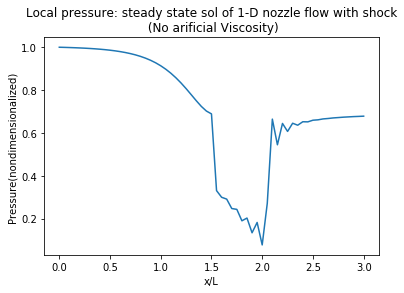

In [20]:
x = np.linspace(0,3,len(rhoResults[:,-1]))
pyplot.plot(x,presResults[:,-1])
pyplot.xlabel('x/L')
pyplot.ylabel('Pressure(nondimensionalized)')
pyplot.title('Local pressure: steady state sol of 1-D nozzle flow with shock\n (No arificial Viscosity)')

As we can see, the solution produced a shock wave in the nozzle which is nothing short of amazing. We didn't program where the shock would be or what would happen befor eand after the shock, but the governing equations forced this behavior to make sure the boundary conditions were met. This is the beauty of modeling physical problems with mathematics. We took something generic and characterized the flow with a set boundary conditions and the model took on a life of its own. Now we can imporove our model by implimenting our atificial viscosity. Let's try $C_x = 0.2$.

In [29]:
rhoResults,tempResults,velResults,presResults,u1ResidualResults,u2ResidualResults,u3ResidualResults,area = main(61,2000,0.2)

Done.


Text(0.5, 1.0, 'Local pressure: steady state sol of 1-D nozzle flow with shock\n (With arificial Viscosity)')

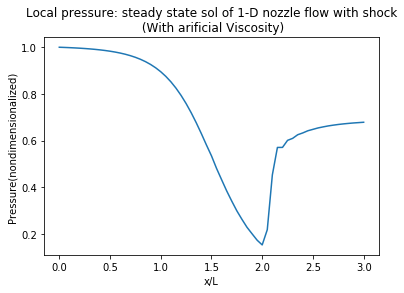

In [26]:
pyplot.plot(x,presResults[:,-1])
pyplot.xlabel('x/L')
pyplot.ylabel('Pressure(nondimensionalized)')
pyplot.title('Local pressure: steady state sol of 1-D nozzle flow with shock\n (With arificial Viscosity)')

Text(0.5, 1.0, 'Local Mach Number: steady state sol of 1-D nozzle flow with shock\n (With arificial Viscosity)')

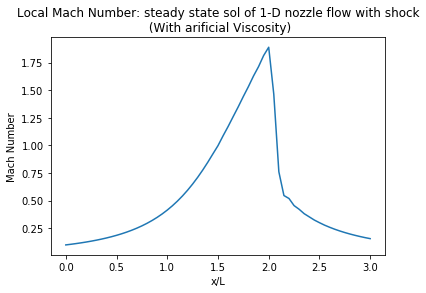

In [27]:
pyplot.plot(x,velResults[:,-1]/tempResults[:,-1]**0.5)
pyplot.xlabel('x/L')
pyplot.ylabel('Mach Number')
pyplot.title('Local Mach Number: steady state sol of 1-D nozzle flow with shock\n (With arificial Viscosity)')

Text(0.5, 1.0, 'Residuals')

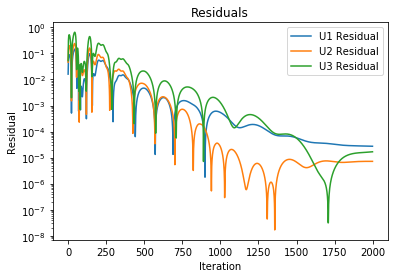

In [28]:
pyplot.plot(abs(u1ResidualResults[int(len(u1ResidualResults)/2),:]),label="U1 Residual")
pyplot.plot(abs(u2ResidualResults[int(len(u1ResidualResults)/2),:]),label="U2 Residual")
pyplot.plot(abs(u3ResidualResults[int(len(u1ResidualResults)/2),:]),label="U3 Residual")
pyplot.yscale('log')
pyplot.xlabel('Iteration')
pyplot.ylabel('Residual')
pyplot.legend()
pyplot.title('Residuals')